In [135]:
using Revise
using QuanticsTCI
using SparseIR
import SparseIR: valueim
using ITensors
import TensorCrossInterpolation as TCI
using LinearAlgebra
import MSSTA
using PyPlot
using PyCall
ITensors.disable_warn_order()


In [66]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["text.latex.preamble"] = [raw"\usepackage{amsmath}"]
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

In [67]:
raw"\usepackage{amsmath}"

"\\usepackage{amsmath}"

In [3]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

function genfunc(beta)
    v = FermionicFreq(1)
    iv = valueim(v, beta)
    gk(kx, ky) = 1 / (iv - ek(kx, ky))
    v = FermionicFreq(1)
    iv = valueim(v, beta)
    function gkb(b)
        nbit = length(b) ÷ 2
        N = 2^nbit
        ikx = frombins(b[1:2:end])
        iky = frombins(b[2:2:end])
        @assert ikx ≤ N
        @assert iky ≤ N
        kx = 2π * (ikx - 1)/N
        ky = 2π * (iky - 1)/N
        return abs.(gk(kx, ky))
    end
    return gkb
end    

function gengkdata(gkb, nbit)
    N = 2^nbit
    gkdata = zeros(Float64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end

gengkdata (generic function with 1 method)

In [4]:
#ek(kx, ky) = 2*cos(kx) + 2*cos(ky) - 1.0
ek(kx, ky) = 2*cos(kx) + 2*cos(ky) + cos(2*kx) + cos(4*ky) - 1.0

ek (generic function with 1 method)

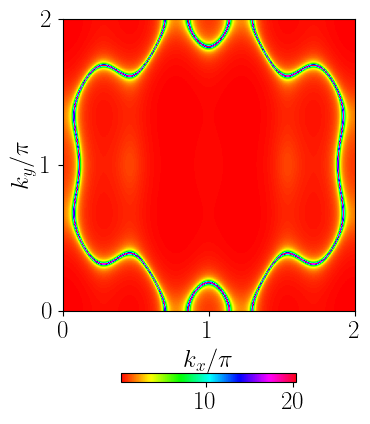

In [5]:
gkdata = gengkdata(genfunc(64.0), 10)

x = LinRange(0.0, 2.0, size(gkdata, 1)+1)[1:end-1]

plt[:pcolormesh](x, x, abs.(gkdata), rasterized=true, cmap="hsv")
ax = plt.gca().set_aspect("equal")
xlabel(L"k_x/\pi")
ylabel(L"k_y/\pi")
xticks([0, 1, 2])
yticks([0, 1, 2])
colorbar(shrink=0.3, location="bottom")

tight_layout()
savefig("gk.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [6]:
betas = [1.0, 4.0, 16.0, 64.0]
tols = [1e-3, 1e-4, 1e-5]
cutoffs_mps = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
nbits = [10, 12]

2-element Vector{Int64}:
 10
 12

In [7]:
sites_nbit = Dict()
for nbit in nbits
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    sites_nbit[nbit] = sites
end

## QTCI

In [8]:
maxiter = 10000
BLAS.set_num_threads(16)

qtts = Dict()
qtt_ranks = Dict()

for tol in tols
    for beta in betas
        for nbit in nbits
            @show tol, beta, nbit
            bx_ = tobins(1, nbit)
            by_ = tobins(2^(nbit-1), nbit)
            func = genfunc(beta)
            firstpivot = TCI.optfirstpivot(func, fill(2, 2*nbit))
            qtt, ranks, errors = TCI.crossinterpolate(
                ComplexF64, func, fill(2, 2*nbit),
                firstpivot, tolerance=tol, maxiter=maxiter, verbosity=1
            )
            qtts[(beta,nbit,tol)] = qtt
            qtt_ranks[(beta,nbit,tol)] = ranks
        end
    end
end

(tol, beta, nbit) = (0.001, 1.0, 10)
rank= 10 , error= 0.1798893573576456
rank= 20 , error= 0.01709773770085765
rank= 30 , error= 0.002608753192540064
(tol, beta, nbit) = (0.001, 1.0, 12)
rank= 10 , error= 0.17947647947316972
rank= 20 , error= 0.016636828779931768
rank= 30 , error= 0.0024801884338378397
(tol, beta, nbit) = (0.001, 4.0, 10)
rank= 10 , error= 0.6084324504647614
rank= 20 , error= 0.1853683137509171
rank= 30 , error= 0.06312109557882734
rank= 40 , error= 0.02230962069448817
rank= 50 , error= 0.0053420276496155316
rank= 60 , error= 0.0010841893189543037
(tol, beta, nbit) = (0.001, 4.0, 12)
rank= 10 , error= 0.6038104363034681
rank= 20 , error= 0.19601162669998765
rank= 30 , error= 0.05660153786797153
rank= 40 , error= 0.02345782608663396
rank= 50 , error= 0.005432198617988686
rank= 60 , error= 0.0015582659895032123
(tol, beta, nbit) = (0.001, 16.0, 10)
rank= 10 , error= 1.5018748579974548
rank= 20 , error= 0.7782207064648413
rank= 30 , error= 0.5258160217614314
rank= 40 , e

## MPS

In [9]:
mpss = Dict()
for beta in betas, nbit in nbits
    data_ref = gengkdata(genfunc(beta), nbit)
    sites = sites_nbit[nbit]
    sitesx = sites[1:2:end]
    sitesy = sites[2:2:end]
    tensor = ITensor(data_ref, vcat(reverse(sitesx), reverse(sitesy)))
    for cutoff in cutoffs_mps
        key = (cutoff, beta, nbit)
        @show key
        mpss[key] = MPS(tensor, sites; cutoff=cutoff)
    end
end

key = (1.0e-6, 1.0, 10)
key = (1.0e-8, 1.0, 10)
key = (1.0e-10, 1.0, 10)
key = (1.0e-12, 1.0, 10)
key = (1.0e-14, 1.0, 10)
key = (1.0e-6, 1.0, 12)
key = (1.0e-8, 1.0, 12)
key = (1.0e-10, 1.0, 12)
key = (1.0e-12, 1.0, 12)
key = (1.0e-14, 1.0, 12)
key = (1.0e-6, 4.0, 10)
key = (1.0e-8, 4.0, 10)
key = (1.0e-10, 4.0, 10)
key = (1.0e-12, 4.0, 10)
key = (1.0e-14, 4.0, 10)
key = (1.0e-6, 4.0, 12)
key = (1.0e-8, 4.0, 12)
key = (1.0e-10, 4.0, 12)
key = (1.0e-12, 4.0, 12)
key = (1.0e-14, 4.0, 12)
key = (1.0e-6, 16.0, 10)
key = (1.0e-8, 16.0, 10)
key = (1.0e-10, 16.0, 10)
key = (1.0e-12, 16.0, 10)
key = (1.0e-14, 16.0, 10)
key = (1.0e-6, 16.0, 12)
key = (1.0e-8, 16.0, 12)
key = (1.0e-10, 16.0, 12)
key = (1.0e-12, 16.0, 12)
key = (1.0e-14, 16.0, 12)
key = (1.0e-6, 64.0, 10)
key = (1.0e-8, 64.0, 10)
key = (1.0e-10, 64.0, 10)
key = (1.0e-12, 64.0, 10)
key = (1.0e-14, 64.0, 10)
key = (1.0e-6, 64.0, 12)
key = (1.0e-8, 64.0, 12)
key = (1.0e-10, 64.0, 12)
key = (1.0e-12, 64.0, 12)
key = (1.0e-14, 64.0, 

In [10]:
function reconst(mps, sites)
    nbit = length(sites) ÷ 2
    sitesx = sites[1:2:end]
    sitesy = sites[2:2:end]
    return reshape(Array(reduce(*, mps), [reverse(sitesx)..., reverse(sitesy)...]), 2^nbit, 2^nbit)
end

reconst (generic function with 1 method)

In [11]:
gk_reconst_qtt = Dict()
gk_ref_qtt = Dict()
for ((beta,nbit,tol),qtt) in qtts
    mps = MSSTA.TCItoMPS(qtt, sites_nbit[nbit])
    data = reconst(mps, sites_nbit[nbit])
    data_ref = gengkdata(genfunc(beta), nbit)
    gk_reconst_qtt[(beta,nbit,tol)] = data
    gk_ref_qtt[(beta,nbit,tol)] = data_ref
    #@show sqrt(norm(data .- data_ref)^2 / norm(data_ref)^2)
end

key = (1.0e-6, 64.0, 12)
key = (1.0e-8, 64.0, 12)
key = (1.0e-10, 64.0, 12)
key = (1.0e-12, 64.0, 12)
key = (1.0e-14, 64.0, 12)


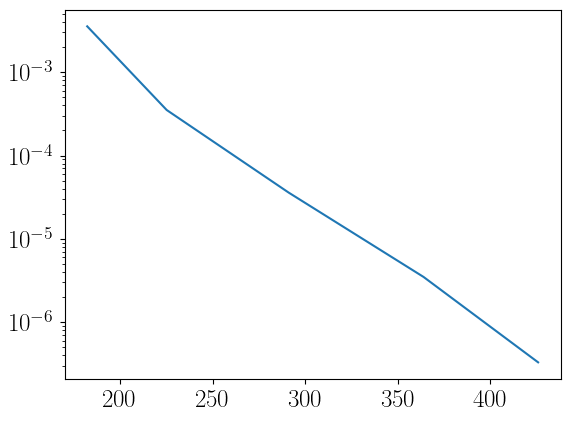

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x151c9bfeec40>

In [12]:
x_mps = []
y_mps = []
beta = betas[end]
nbit = nbits[end]
for cutoff in cutoffs_mps
    key = (cutoff, beta, nbit)
    @show key
    data = reconst(mpss[key], sites_nbit[nbit])
    data_ref = gengkdata(genfunc(beta), nbit)
    push!(x_mps, maximum(dim.(linkinds(mpss[key]))))
    push!(y_mps, norm(data .- data_ref) / norm(data_ref))
end

semilogy(x_mps, y_mps)

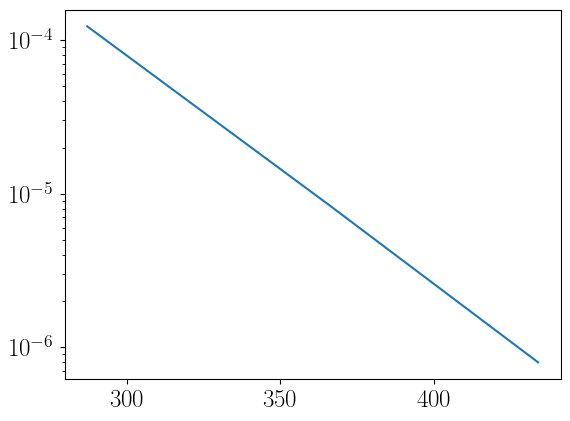

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x151c98d6da90>

In [13]:
x_qtt = []
y_qtt = []
beta = betas[end]
nbit = nbits[end]
for tol in tols
    data = gk_reconst_qtt[(beta,nbit,tol)]
    data_ref = gk_ref_qtt[(beta,nbit,tol)]
    push!(x_qtt, TCI.rank(qtts[(beta,nbit,tol)]))
    push!(y_qtt, norm(data .- data_ref) / norm(data_ref))
end

semilogy(x_qtt, y_qtt)

In [14]:
nbit = nbits[end]

plotdata_qtt = Dict()
plotdata_mps = Dict()

for beta in betas
    # QTT
    x_qtt = []
    y_qtt = []
    for tol in tols
        data = gk_reconst_qtt[(beta,nbit,tol)]
        data_ref = gk_ref_qtt[(beta,nbit,tol)]
        push!(x_qtt, TCI.rank(qtts[(beta,nbit,tol)]))
        push!(y_qtt, norm(data .- data_ref) / norm(data_ref))
    end
    plotdata_qtt[beta] = (x_qtt, y_qtt)

    # MPS
    x_mps = []
    y_mps = []
    for cutoff in cutoffs_mps
        key = (cutoff, beta, nbit)
        @show key
        data = reconst(mpss[key], sites_nbit[nbit])
        data_ref = gengkdata(genfunc(beta), nbit)
        push!(x_mps, maximum(dim.(linkinds(mpss[key]))))
        push!(y_mps, norm(data .- data_ref) / norm(data_ref))
    end
    plotdata_mps[beta] = (x_mps, y_mps)

end

key = (1.0e-6, 1.0, 12)
key = (1.0e-8, 1.0, 12)
key = (1.0e-10, 1.0, 12)
key = (1.0e-12, 1.0, 12)
key = (1.0e-14, 1.0, 12)
key = (1.0e-6, 4.0, 12)
key = (1.0e-8, 4.0, 12)
key = (1.0e-10, 4.0, 12)
key = (1.0e-12, 4.0, 12)
key = (1.0e-14, 4.0, 12)
key = (1.0e-6, 16.0, 12)
key = (1.0e-8, 16.0, 12)
key = (1.0e-10, 16.0, 12)
key = (1.0e-12, 16.0, 12)
key = (1.0e-14, 16.0, 12)
key = (1.0e-6, 64.0, 12)
key = (1.0e-8, 64.0, 12)
key = (1.0e-10, 64.0, 12)
key = (1.0e-12, 64.0, 12)
key = (1.0e-14, 64.0, 12)


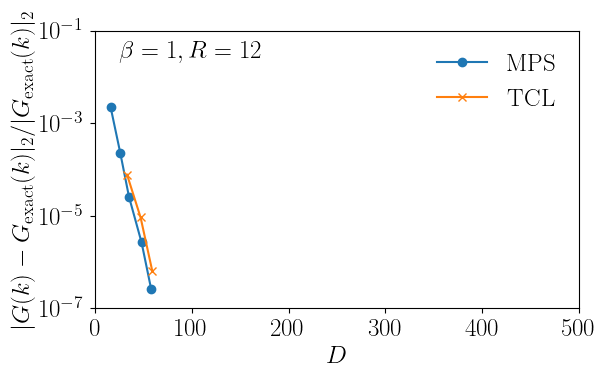

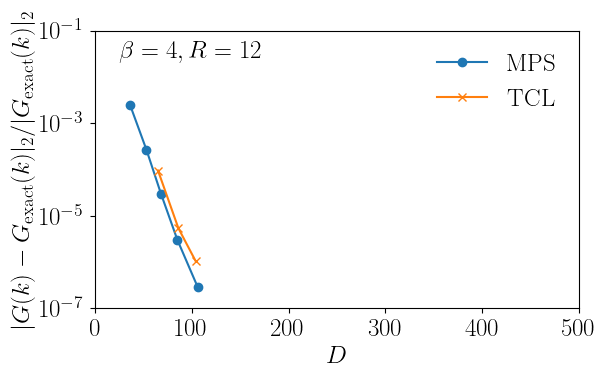

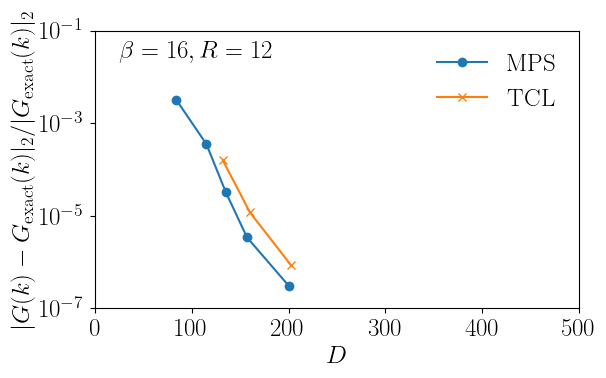

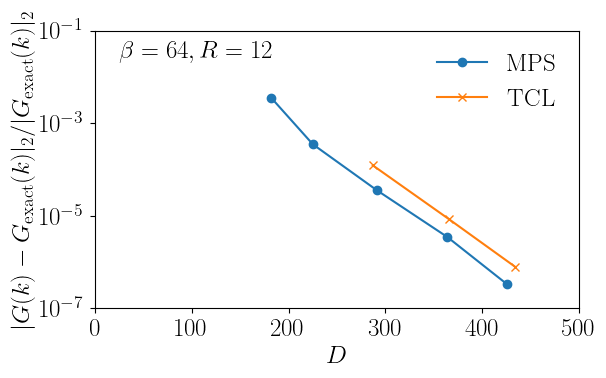

In [15]:
nbit = nbits[end]

for beta in betas
    fig = figure(figsize=(6.4, 4.0))
    annotate(L"\beta=%$(Int(beta)), R=%$(nbit)", xycoords="axes fraction", xy=(0.05, 0.9), fontsize=18)

    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="o", label="MPS")
    
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="x", label="TCL")

    xlabel(L"D")
    ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
    xlim([0, 500])
    ylim([1e-7, 1e-1])
    legend(frameon=false)
    
    tight_layout()
    savefig("gk_scaling_beta$(beta)_nbit$(nbit).pdf", bbox_inches="tight", transparent=true, rasterized=true)
    
    display(gcf())
    close(gcf())
end

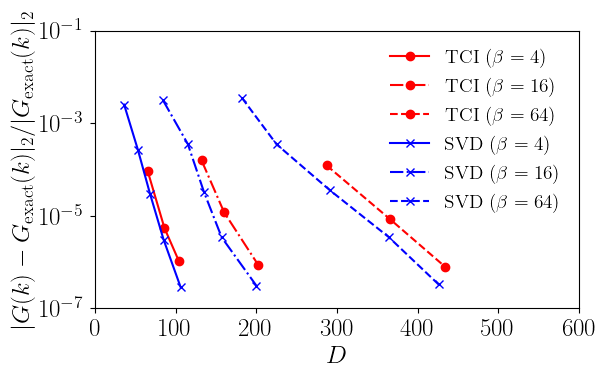

In [16]:
nbit = nbits[end]

pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

fig = figure(figsize=(6.4, 4.0))
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D")
ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
xlim([0, 600])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=14)

tight_layout()
savefig("gk_scaling_nbit$(nbit).pdf", bbox_inches="tight", transparent=true, rasterized=true)

display(gcf())
close(gcf())

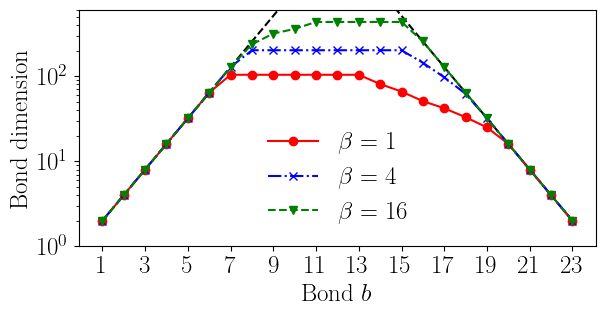

In [121]:
nc = 1
fig = figure(figsize=(6.4, nc*3.5))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

maxL = 1
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    key = (beta, nbits[end], tols[end])
    mps = MSSTA.TCItoMPS(qtts[key])
    y = dim.(linkinds(mps))
    x = 1:length(y)
    maxL = max(maxL, length(y))
    if i == 1
        maxy = MSSTA.maxlinkdims(siteinds(mps))
        semilogy(x, maxy, marker="", c="k", label="", ls="--")
    end
    semilogy(x, dim.(linkinds(mps)), marker=markers[i], c=pcolors[i], label=L"\beta=%$(Int(betas[i]))", ls=ls[i])
end
#semilogy(MSSTA.linkdims(mps), label="", ls="--", c="k")

xlabel("Bond " * L"b")
xticks(1:2:maxL, fontsize=18)
ylabel("Bond dimension")
ylim([1, 600])
legend(frameon=false)

tight_layout()
savefig("bond_dims.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())



maximum(abs, data .- data_ref) = 0.0002193054280787976
Dmax = 434


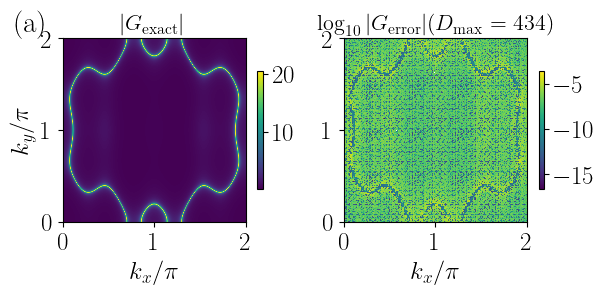

In [118]:
fig = figure(figsize=(6.4, 6.4))

let
    
    nbit = nbits[end]
    tol = tols[end]
    beta = betas[end]
    data = gk_reconst_qtt[(beta,nbit,tol)]
    data_ref = gk_ref_qtt[(beta,nbit,tol)]
    @show maximum(abs, data .- data_ref)
    mps = MSSTA.TCItoMPS(qtts[(beta,nbit,tol)])
    Dmax = maximum(dim.(linkinds(mps)))
    @show Dmax
    
    x = LinRange(0.0, 2.0, size(data_ref, 1)+1)[1:end-1]

    subplot(1, 2, 1)
    #title(L"G(\boldsymbol{k}, \mathrm{i}\omega_0)")
    annotate("(a)", xycoords="axes fraction", xy=(-0.26,1.04), fontsize=21)
    title(L"|G_\mathrm{exact}|", fontsize=16)
    #plt[:pcolormesh](x, x, abs.(data_ref), rasterized=true, cmap="hsv")
    plt[:pcolormesh](x, x, abs.(data_ref), rasterized=true)
    ax = plt.gca().set_aspect("equal")
    xlabel(L"k_x/\pi")
    ylabel(L"k_y/\pi")
    xticks([0, 1, 2])
    yticks([0, 1, 2])
    colorbar(shrink=0.2)

    subplot(1, 2, 2)
    title(L"\log_{10}|G_\mathrm{error}| (D_\mathrm{max}=%$(Dmax))", fontsize=16)
    plt[:pcolormesh](x, x, log10.(abs.(data .- data_ref)), rasterized=true)
    #annotate(L"D_\mathrm{max}=%$(Dmax)", xycoords="axes fraction", xy=(0.0,0.85), fontsize=18, weight="bold")
    ax = plt.gca().set_aspect("equal")
    xlabel(L"k_x/\pi")
    #ylabel(L"k_y/\pi")
    xticks([0, 1, 2])
    yticks([0, 1, 2])
    #clim([-16, -4])
    colorbar(shrink=0.2)

    tight_layout()
end

savefig("dyson-a.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())
#push!(x_qtt, TCI.rank(qtts[(beta,nbit,tol)]))
#push!(y_qtt, norm(data .- data_ref) / norm(data_ref))

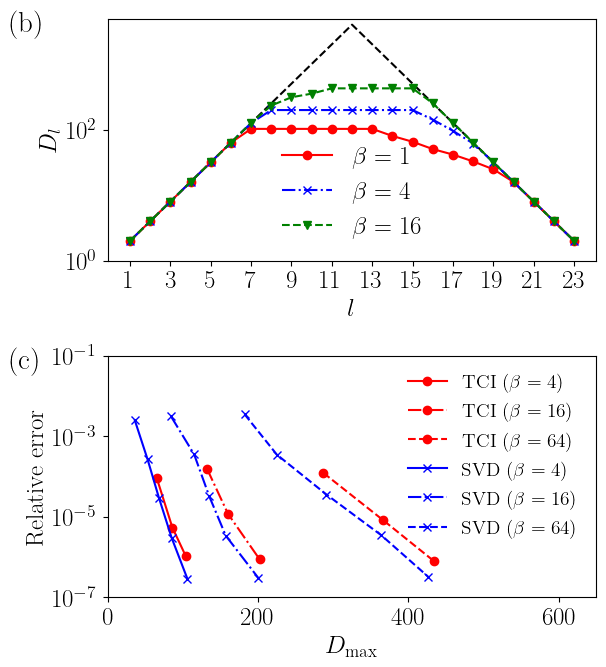

In [126]:
nc = 2
fig = figure(figsize=(6.4, nc*3.5))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

# subplot1
subplot(nc, 1, 1)
annotate("(b)", xycoords="axes fraction", xy=(-0.2,0.95), fontsize=21)
maxL = 1
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    key = (beta, nbits[end], tols[end])
    mps = MSSTA.TCItoMPS(qtts[key])
    y = dim.(linkinds(mps))
    x = 1:length(y)
    maxL = max(maxL, length(y))
    if i == 1
        maxy = MSSTA.maxlinkdims(siteinds(mps))
        semilogy(x, maxy, marker="", c="k", label="", ls="--")
    end
    semilogy(x, dim.(linkinds(mps)), marker=markers[i], c=pcolors[i], label=L"\beta=%$(Int(betas[i]))", ls=ls[i])
end
#semilogy(MSSTA.linkdims(mps), label="", ls="--", c="k")

xlabel(L"l")
xticks(1:2:maxL, fontsize=18)
#minorticks_on()
ylabel(L"D_l")
ylim([1, 5000])
legend(frameon=false)

tight_layout()

# subplot2
subplot(nc, 1, 2)
annotate("(c)", xycoords="axes fraction", xy=(-0.2,0.95), fontsize=21)
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D_\mathrm{max}")
#ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
ylabel("Relative error")
xlim([0, 650])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=14)

tight_layout()

savefig("dyson2.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

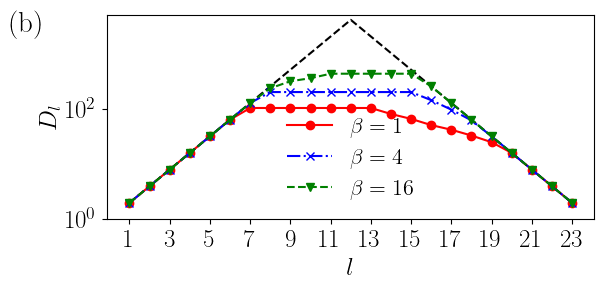

In [140]:
nc = 1
fig = figure(figsize=(6.4, nc*3.2))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(b)", xycoords="axes fraction", xy=(-0.2,0.92), fontsize=21)
maxL = 1
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    key = (beta, nbits[end], tols[end])
    mps = MSSTA.TCItoMPS(qtts[key])
    y = dim.(linkinds(mps))
    x = 1:length(y)
    maxL = max(maxL, length(y))
    semilogy(x, dim.(linkinds(mps)), marker=markers[i], c=pcolors[i], label=L"\beta=%$(Int(betas[i]))", ls=ls[i])
    if i == 1
        maxy = MSSTA.maxlinkdims(siteinds(mps))
        semilogy(x, maxy, marker="", c="k", label="", ls="--")
    end
end

#ticker = matplotlib["ticker"]
#plt.axes().yaxis.set_minor_locator(ticker[:MultipleLocator](5))

xlabel(L"l")
xticks(1:2:maxL, fontsize=18)
ylabel(L"D_l")
ylim([1, 5000])
legend(frameon=false, fontsize=16)

tight_layout()

savefig("dyson-b.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

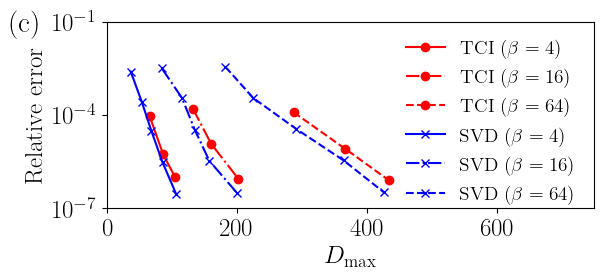

In [116]:
nc = 1
fig = figure(figsize=(6.4, nc*3.1))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(c)", xycoords="axes fraction", xy=(-0.2,0.95), fontsize=21)
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D_\mathrm{max}")
#ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
ylabel("Relative error")
xlim([0, 750])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=14)

tight_layout()

savefig("dyson-c.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

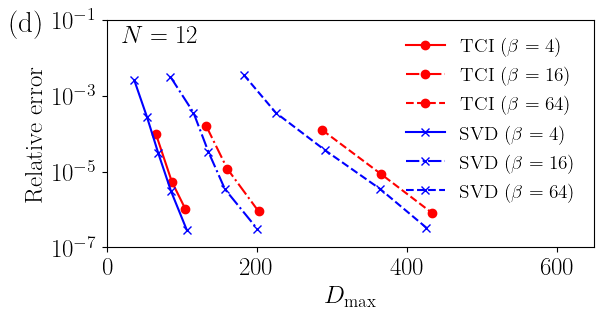

In [100]:
nc = 1
fig = figure(figsize=(6.4, nc*3.5))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(d)", xycoords="axes fraction", xy=(-0.2,0.95), fontsize=21)
annotate(L"N=%$(nbits[end])", xycoords="axes fraction", xy=(0.03,0.9), fontsize=18)

for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_qtt, y_qtt = plotdata_qtt[beta]
    semilogy(x_qtt, y_qtt, marker="o", label=L"\mathrm{TCI}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[1])
end
    
for (i, beta) in enumerate([4.0, 16.0, 64.0])
    x_mps, y_mps = plotdata_mps[beta]
    semilogy(x_mps, y_mps, marker="x", label=L"\mathrm{SVD}~(\beta=%$(Int(beta)))", ls=ls[i], c=pcolors[2])
end

xlabel(L"D_\mathrm{max}")
#ylabel(L"|G(k) - G_\mathrm{exact}(k)|_2 / |G_\mathrm{exact}(k)|_2")
ylabel("Relative error")
xlim([0, 650])
ylim([1e-7, 1e-1])
legend(frameon=false, fontsize=14)

tight_layout()

savefig("dyson-d.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())